In [ ]:
# Meest gebruikt: https://mkang32.github.io/python/2020/12/15/prophet-intro.html
# Beste Tutorial: https://github.com/nachi-hebbar/FB-Prophet-Time-Series-Forecasting/blob/main/FB_Prophet_YouTube.ipynb
# behorend by YouTube video: https://www.youtube.com/watch?v=2vF2xTUXJwM

### Import libraries

In [1]:
import pandas as pd
import mlflow
import warnings
import numpy as np

warnings.filterwarnings("ignore")

#plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric, add_changepoints_to_plot,plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation

from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

### Read the file with sales data

In [3]:
df = pd.read_csv(r'C:\Users\nico_\OneDrive\Portfolio\Demand Prediction with Prophet\data\sales.csv', encoding='latin1')
df.head()

,Order Item ID,Order ID,date,Order Time,qty,prod_code,Customer ID,RegCode,Gross Sales,Discount %,Gross Profit,Purchase Price,Net Tot Sales,Discount,Net Tot Profit
0,1502,615,2017-03-09,01:41:00,5,Go-Wo-NMDVGP,2827,LA-SA-BRAZIL,250,0.15,125,125,1.063,187.5,437.50
1,2124,855,2015-01-13,11:11:00,5,Go-Wo-NMDVGP,4535,LA-CA-MEXICO,250,0.16,125,125,1.050,200.0,425
2,2793,1123,2015-01-28,01:32:00,5,Go-Wo-NMDVGP,2311,LA-SA-ARGENTI,250,0.15,125,125,1.063,187.5,437.50
3,3429,1388,2015-01-21,05:55:00,5,Go-Wo-NMDVGP,12046,LA-SA-BOLIVIA,250,0.00,125,125,1.250,0.0,625
4,3987,1598,2015-01-24,07:30:00,5,Go-Wo-NMDVGP,10784,LA-CA-HONDURA,250,0.03,125,125,1.213,37.5,587.50


In [4]:
df.columns

Index(['order_item_id', 'order_id', 'date', 'order_time', 'qty', 'prod_code',
       'customer_id', 'regcode', 'gross_sales', 'discount_%', 'gross_profit',
       'purchase_price', 'net_tot_sales', 'discount', 'net_tot_profit'],
      dtype='object')

In [23]:
df['prod_code'].nunique()

112

In [24]:
df.shape

(30871, 15)

In [4]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
min(df['date']), max(df['date'])

('2015-01-01', '2017-12-31')

### Plot potential outliers in the Discount column

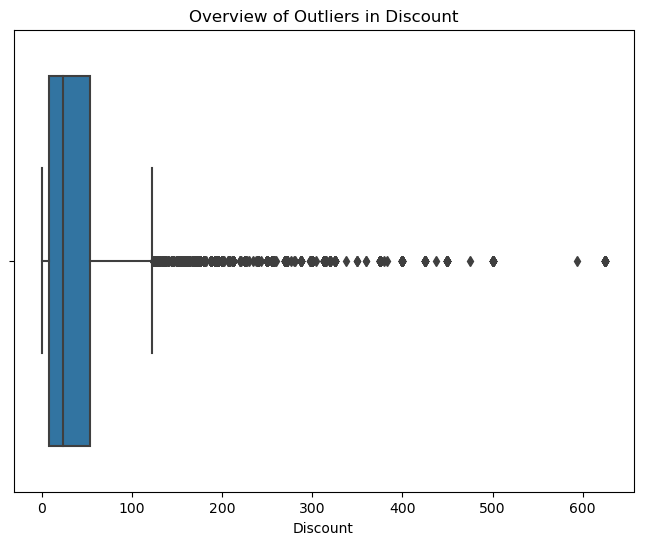

In [26]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['discount'])
plt.title('Overview of Outliers in Discount')
plt.xlabel('Discount')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Discount'])
plt.title('Overview of Outliers in Discount')
plt.xlabel('Discount')
plt.show()

### Analyse which product is ordered the most

In [5]:
# Group the dataframe by 'prod_code' and count the number of unique dates for each product
df_grouped = df.groupby('prod_code')['date'].nunique()

# Find the maximum number of unique dates
max_dates = df_grouped.max()

# Filter the grouped dataframe to get the products that have the maximum number of unique dates
df_most_ordered = df_grouped[df_grouped == max_dates]

# Print the result
print(df_most_ordered)

prod_code
Go-Wo-NMDVGP    905
Name: date, dtype: int64


### Continue with 1 product code

In [6]:
df_Go_Wo_NMDVGP = df.query("prod_code == 'Go-Wo-NMDVGP'")

In [7]:
df_Go_Wo_NMDVGP.head()

,order_item_id,order_id,date,order_time,qty,prod_code,customer_id,regcode,gross_sales,discount_%,gross_profit,purchase_price,net_tot_sales,discount,net_tot_profit
0,1502,615,2017-03-09,01:41:00,5,Go-Wo-NMDVGP,2827,LA-SA-BRAZIL,250,0.15,125,125,1.063,187.5,437.50
1,2124,855,2015-01-13,11:11:00,5,Go-Wo-NMDVGP,4535,LA-CA-MEXICO,250,0.16,125,125,1.050,200.0,425
2,2793,1123,2015-01-28,01:32:00,5,Go-Wo-NMDVGP,2311,LA-SA-ARGENTI,250,0.15,125,125,1.063,187.5,437.50
3,3429,1388,2015-01-21,05:55:00,5,Go-Wo-NMDVGP,12046,LA-SA-BOLIVIA,250,0.00,125,125,1.250,0.0,625
4,3987,1598,2015-01-24,07:30:00,5,Go-Wo-NMDVGP,10784,LA-CA-HONDURA,250,0.03,125,125,1.213,37.5,587.50


In [8]:
df_grouped = df_Go_Wo_NMDVGP.groupby('date')['qty'].sum().reset_index()

In [9]:
df_grouped.columns = ['ds', 'y']
df_grouped['ds'] = pd.to_datetime(df_grouped['ds'])
df_grouped = df_grouped[df_grouped['ds'] <= '2017-09-30']

In [10]:
df_grouped.head()

,ds,y
0,2015-01-01,3
1,2015-01-02,9
2,2015-01-03,4
3,2015-01-04,11
4,2015-01-05,4


### Plot sold qty of Go-Wo-NMDVGP over time in a line chart

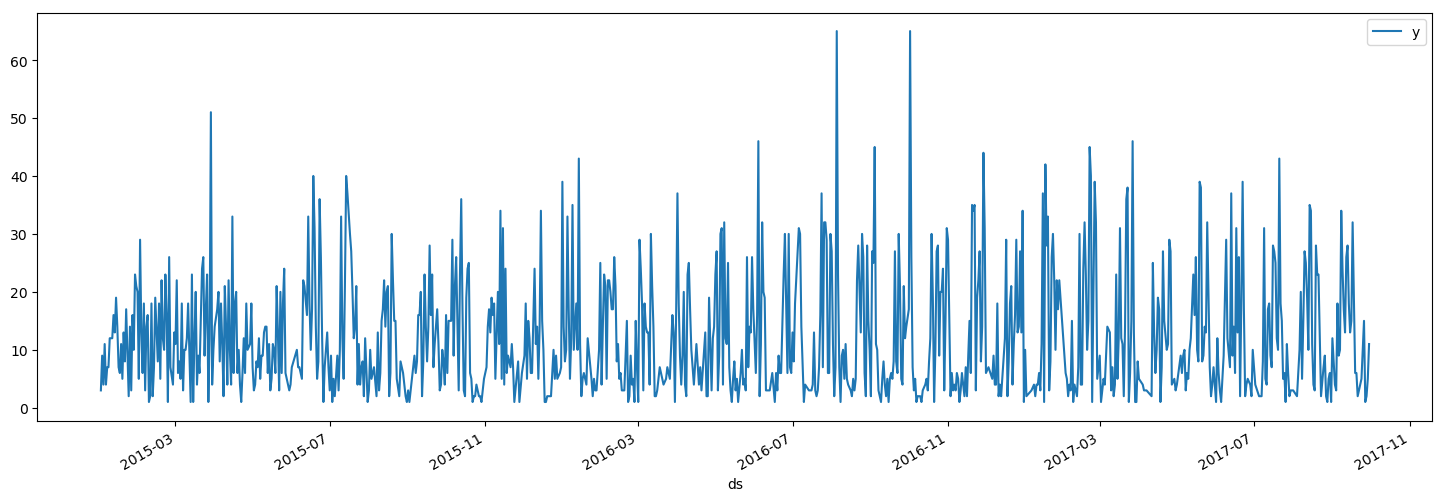

In [11]:
df_grouped.plot(x='ds',y='y',figsize=(18,6))

### Create Train and Test Set

In [12]:
# split data 
train = df_grouped[df_grouped['ds'] < pd.Timestamp('2017-03-01')]
test = df_grouped[df_grouped['ds'] >= pd.Timestamp('2017-03-01')]
print(f"Number of sales days in train data: {len(train)}")
print(f"Number of sales days in test data: {len(test)}")

Number of sales days in train data: 701
Number of sales days in test data: 182


### Create the Prophet Model and fit it to the Train set

In [13]:
model_Go_Wo_NMDVGP = Prophet(weekly_seasonality='auto', holidays=None)
model_Go_Wo_NMDVGP.fit(train)

14:37:55 - cmdstanpy - INFO - Chain [1] start processing
14:37:55 - cmdstanpy - INFO - Chain [1] done processing


### Create future dataframe (52 weeks into the future)

In [14]:
# future = m.make_future_dataframe(periods=365) #MS for monthly, H for hourly
# forecast = m.predict(future)

# future dataframe - placeholder object
future = model_Go_Wo_NMDVGP.make_future_dataframe(periods=52, freq='W') 

### Make the forecast

In [15]:
# predict the future
forecast = model_Go_Wo_NMDVGP.predict(future)

In [16]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
748,2018-01-28,15.410543,2.760396,29.054185
749,2018-02-04,14.869249,2.295854,27.262750
750,2018-02-11,15.680746,3.077625,28.679334
751,2018-02-18,16.804668,4.282006,29.462527
752,2018-02-25,16.773517,3.468028,30.172010


### Plot the forecast of the product

##### Using Matplotlib

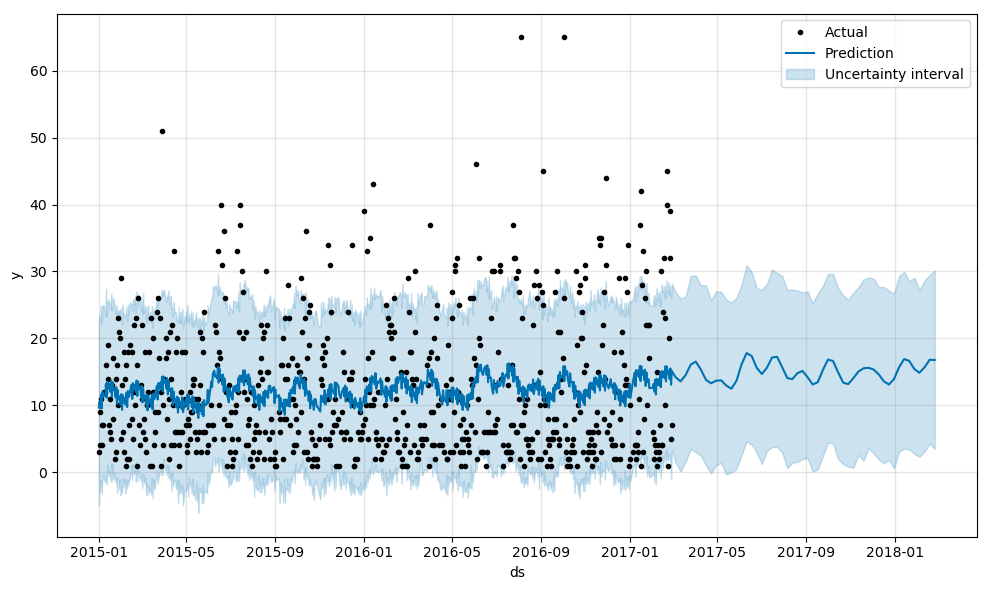

In [17]:
# Prophet's own plotting tool to see 
fig = model_Go_Wo_NMDVGP.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
plt.show()

##### Using Plotly

In [18]:
plot_plotly(model_Go_Wo_NMDVGP,forecast)

### Plot trend components with plot_components_plotly

In [19]:
plot_components_plotly(model_Go_Wo_NMDVGP, forecast)

### Plot changepoints with add_changepoints_to_plot

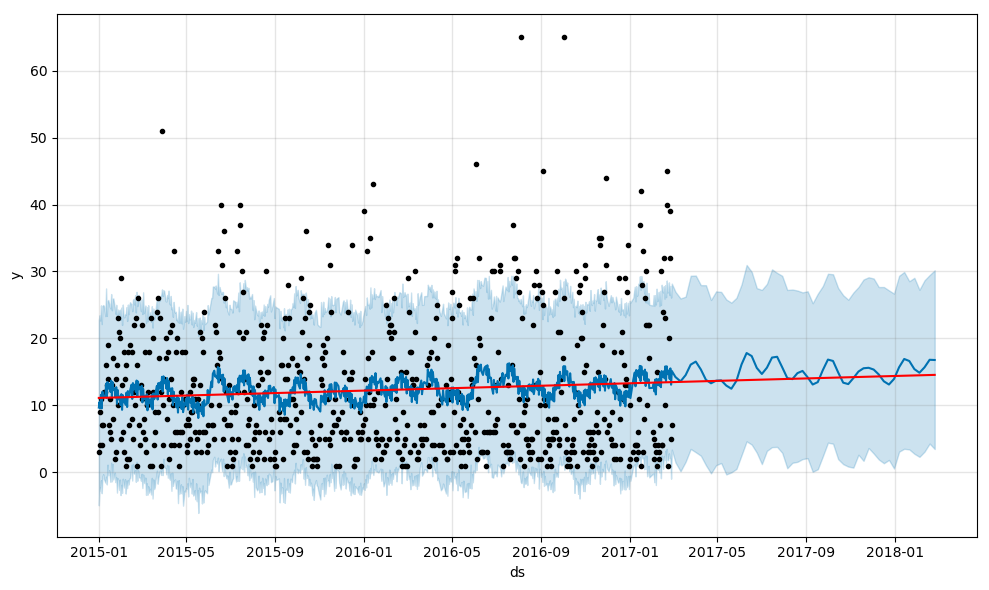

In [20]:
# plot change points
fig = model_Go_Wo_NMDVGP.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model_Go_Wo_NMDVGP, forecast)

### Calculate RMSE and MAE

In [21]:
predictions = forecast.iloc[-len(test):]['yhat']
actuals = test['y']
mae = mean_absolute_error(actuals, predictions)

print(f"RMSE: {round(rmse(predictions, actuals))}")
print(f"MAE: {round(mae)}")

RMSE: 11
MAE: 9
